In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
from popsed import prior
import gc

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : logmstar, InvSigmoid(kappa1_sfh), InvSigmoid(kappa2_sfh), InvSigmoid(kappa3_sfh), log10(fburst), log10(tburst), logzsol, log10(dust1), log10(dust2), dust_index, log10(redshift)**

We still need penalty on logzsol and dust_index

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

### Try to test how kappa transforms into beta

In [30]:
from popsed.nde import _inv_beta_cdf, _beta_cdf
def gen_truth(N_samples=5000):
    ncomp = 4
    priors = prior.load_priors([
            # flat dirichilet priors for SFH
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.6),
            prior.UniformPrior(0., 1.,),
            prior.UniformPrior(0., 1.,),
            # uniform priors on the mass fraction of burst
            prior.TruncatedNormalPrior(0, 1, 0.9, 0.6, label='fburst'),
            # uniform priors on star-burst lookback time
            prior.TruncatedNormalPrior(1e-2, 13.27, 12, 7, label='tburst'),
            # uniform priors on log-metallicity, absolute Z
            prior.TruncatedNormalPrior(-4.34, -1.35, -5, 0.9, label='gamma_zh1'),
            prior.TruncatedNormalPrior(-4.34, -1.35, -3.4, 0.6, label='gamma_zh2'),
            # uniform priors on dust1
            prior.TruncatedNormalPrior(0., 3., 1, 0.8, label='dust1'),
            # uniform priors on dust2
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.8, label='dust2'),
            # uniform priors on dust_index
            prior.TruncatedNormalPrior(-3., 1., 2, 2, label='dust_index'),
        ])
    
    _thetas_unt = np.array([priors.sample() for i in range(N_samples)])
#     _thetas_unt[:, 1] = _beta_cdf(np.random.uniform(0, 1, N_samples), 2, 1)
    for i in range(3):
        _thetas_unt[:, i:i + 1] = _inv_beta_cdf(_thetas_unt[:, i:i + 1], 3 - i, 1)
    _thetas = np.hstack([
#                _thetas_unt[:, 0:1], 
               prior.FlatDirichletPrior(4).transform(_thetas_unt[:, 0:3]), 
               _thetas_unt[:, 3:]])
    
    return _thetas, _thetas_unt

In [47]:
# z_mass_mock = np.load('./NDE/GAMA/NMF/z_mass_mock.npy')
# z_mass_mock = np.load('./reference_catalog/GAMA/gama_clean_z_mass_lambdar.npy')[:, :2]
z_mass_mock = np.load('./reference_catalog/GAMA/gama_clean_z_mass_dr3_apmatch.npy')[:, :2]
z_mass_mock = z_mass_mock[(z_mass_mock[:, 1] > 7.5) & (z_mass_mock[:, 1] < 13) & (z_mass_mock[:, 0] < 0.65)]
z_mass_mock = z_mass_mock[np.random.randint(0, len(z_mass_mock), 50000)]

In [48]:
_thetas, _thetas_unt = gen_truth(N_samples=len(z_mass_mock)) # slow

In [49]:
params = np.hstack([_thetas, z_mass_mock])
params_unt = np.hstack([_thetas_unt, z_mass_mock])
params[:, 6:8] = 10**params[:, 6:8]
params_unt[:, 5:7] = 10**params_unt[:, 5:7]

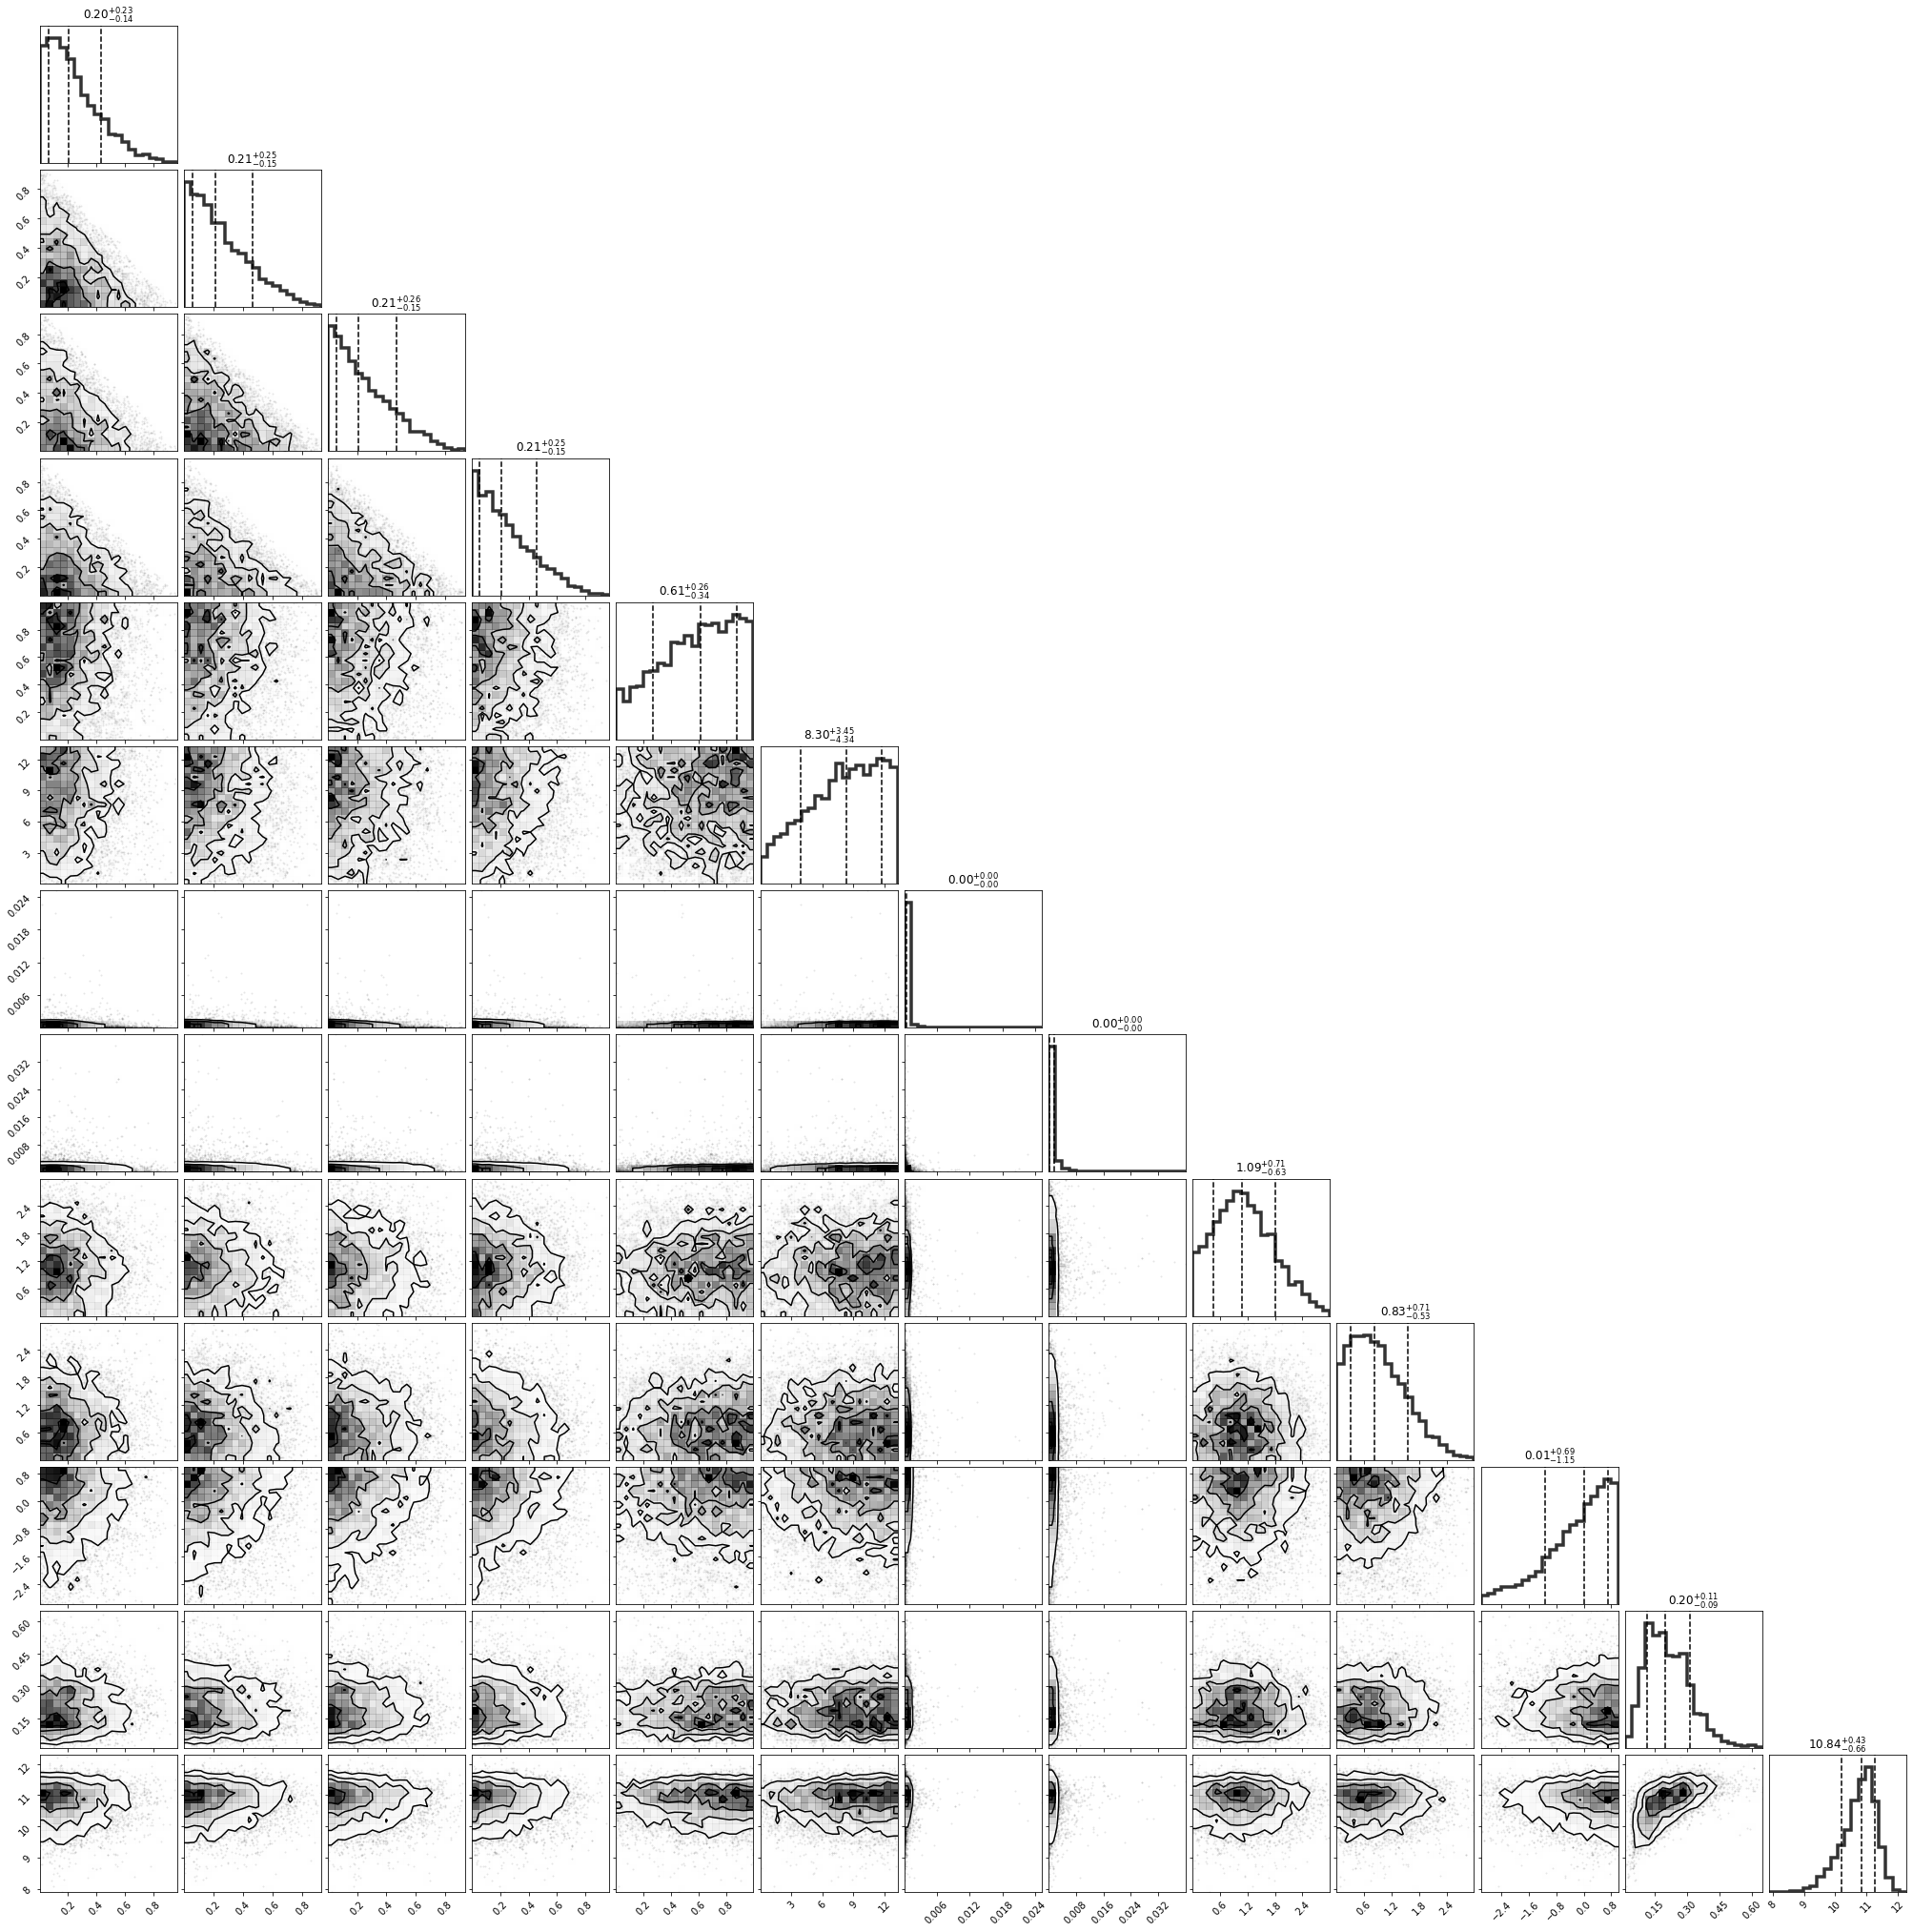

In [50]:
figure = corner.corner(params[np.random.randint(0, len(params), 5000)],
                       quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [51]:
name = 'NMF_ZH'
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')

if name == 'NMF_ZH':
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
else:
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'logzsol',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
speculator = SuperSpeculator(
    speculators_dir=spec_dir,
    str_wbin=['.w1000_2000',
              '.w2000_3600',
              '.w3600_5500',
              '.w5500_7410',
              '.w7410_60000'],
    wavelength=wave,
    params_name=params_name,
    device='cuda', use_speclite=True)
gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)

noise = 'gama'
noise_model_dir = './noise_model/gama_noise_model_mag_dr3_apmatch.npy'

In [52]:
np.save('./NDE/GAMA/NMF/mock_ZH_params.npy', params_unt)

test_par = torch.Tensor(params_unt).to('cuda')

mags = speculator._predict_mag_with_mass_redshift(test_par, noise='gama', SNR=1,
                                           noise_model_dir=noise_model_dir).detach().cpu().numpy()
np.save('./NDE/GAMA/NMF/mock_ZH_mags_gama_apmatch_noise.npy', mags)
del mags
torch.cuda.empty_cache()
gc.collect()

452503

#### Load GAMA photometry catalog

In [11]:
from astropy.table import Table
from popsed.utils import flux2mag, sigma_flux2mag

In [53]:
name = 'NMF_ZH'
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')

if name == 'NMF_ZH':
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
else:
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'logzsol',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
speculator = SuperSpeculator(
    speculators_dir=spec_dir,
    str_wbin=['.w1000_2000',
              '.w2000_3600',
              '.w3600_5500',
              '.w5500_7410',
              '.w7410_60000'],
    wavelength=wave,
    params_name=params_name,
    device='cuda', use_speclite=True)
gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)

noise = 'gama'
noise_model_dir = './noise_model/gama_noise_model_mag_dr3_apmatch.npy'

In [54]:
X_data = np.load('./NDE/GAMA/NMF/mock_ZH_mags_gama_apmatch_noise.npy')[:, :]
print('Total number of samples:', len(X_data))

Total number of samples: 50000


In [55]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [16]:
# Determine the intrinsic sampling loss
X_datas = []
for i in range(5):
    ind = np.random.randint(0, len(X_data), 10000)
    X_datas.append(torch.Tensor(X_data[ind]).to('cuda'))
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.002, 'scaling': 0.9})
intr_loss = []
for i in range(5):
    dataloader = DataLoader(X_data, batch_size=10000, shuffle=True)
    data_loss = 0.
    for x in dataloader:
        data_loss += L(X_datas[i], x.to('cuda'))
    loss = data_loss / len(dataloader)
    intr_loss.append(loss.item())

print("Intrinsic sampling loss:", np.mean(intr_loss), '+-', np.std(intr_loss))
del X_datas
gc.collect()
torch.cuda.empty_cache()

Intrinsic sampling loss: 0.2325529545545578 +- 0.0034118794197190807


In [56]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [57]:
_prior_NDE = speculator.bounds.copy()
_prior_NDE[-2] = np.array([0., 0.8])
_prior_NDE[-1] = np.array([7.5, 13.])

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

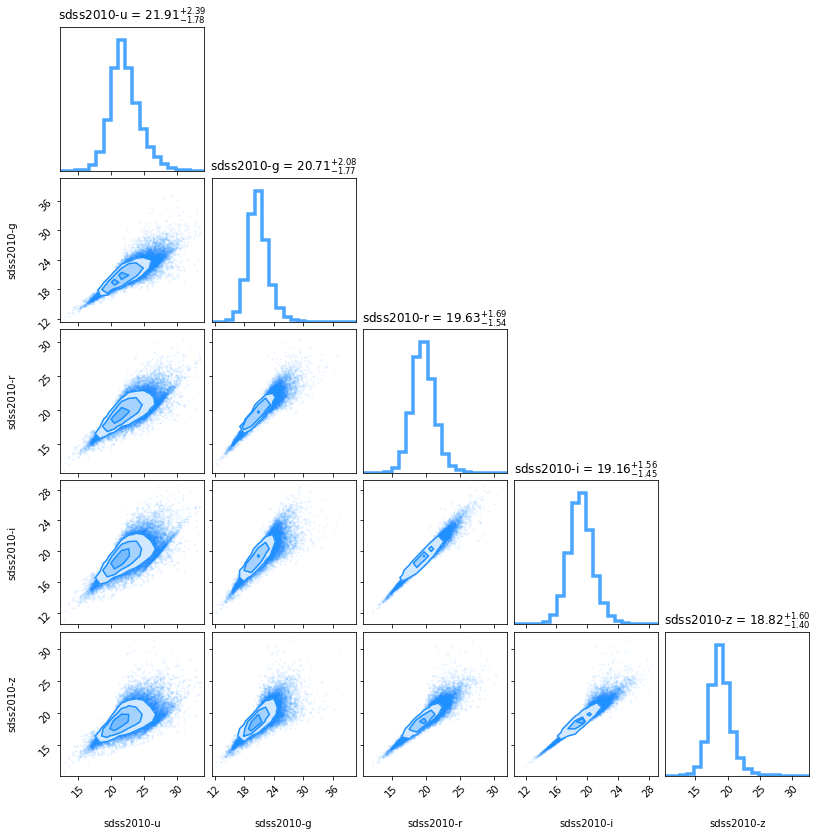

In [58]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = gama_filters

figure = corner.corner(X_data,
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [59]:
X_train, X_vali = train_test_split(X_data, test_size=0.15)
if name == 'NMF_ZH':
    Y_train = torch.ones(len(X_train), 12)
else:
    Y_train = torch.ones(len(X_train), 11)

### now we provide the redshift distribution to it

In [60]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

In [61]:
seed = 42
np.random.seed(seed)

_bounds = speculator.bounds.copy()
_bounds = np.zeros_like(_bounds)
_bounds = np.vstack([-np.abs(np.random.normal(size=len(_bounds)) / 20), 
                   np.abs(np.random.normal(size=len(_bounds)) / 20)]).T

_stds = np.ones(len(_bounds))

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name=name,
                                              num_transforms=20,  # 10
                                              num_bins=50,  # how smashed it is. 10
                                              hidden_features=100,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=True, 
                                              NDE_prior=_prior_NDE,#np.vstack([_prior_NDE[:-2], _prior_NDE[-1:]])
                                             )

In [62]:
NDE_theta.build(
    Y_train,
    X_train,
    filterset=gama_filters,
    z_score=False,
    optimizer='adam')
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name

print('Total number of params in the model:', 
      sum(p.numel() for p in NDE_theta.net.parameters() if p.requires_grad))

NDE_theta.external_redshift_data = None

[-1.10025099e-02  9.06084224e-02  5.44522476e-02 -1.37318456e-02
 -1.98002746e-03 -7.42960064e-03 -7.17372556e-02  5.60301352e-02
  3.46878596e-02  7.38926088e-05 -2.26244220e-02  6.83931713e-02]
Total number of params in the model: 2631000


In [63]:
# del X_data
gc.collect()
torch.cuda.empty_cache()

In [64]:
noise = 'gama'
max_epochs = 30
anneal_tau = 7.5
anneal_coeff = 20
max_lr = 3e-4
NDE_theta.output_dir = "./NDE/GAMA/anneal/mock/test_zh/"

blurs = [0.3, 0.3, 0.2, 0.1, 0.1,
         0.1, 0.05, 0.05, 0.05] + [0.002] * max_epochs
snrs = [1 + anneal_coeff * np.exp(- anneal_tau / max_epochs * i)
        for i in range(max_epochs)]  # larger anneal_coeff, after annealing
steps = 30

try:
    print('### Training NDE for seed {0}'.format(seed))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                    max_lr=max_lr,
                                                    steps_per_epoch=steps,
                                                    epochs=max_epochs)
    for i, epoch in enumerate(range(max_epochs)):
        np.save(os.path.join(NDE_theta.output_dir, f'{NDE_theta.method}_{NDE_theta.seed}_sample_{i+1}.npy'),
                NDE_theta.sample(5000).detach().cpu().numpy())

        print('    Epoch {0}'.format(epoch))
        print('\n\n')
        print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
        NDE_theta.train(n_epochs=steps,
                        speculator=speculator,
                        add_penalty=False,
                        n_samples=10000,
                        noise=noise,
                        noise_model_dir=noise_model_dir,
                        SNR=snrs[i],
                        sinkhorn_kwargs={
                            'p': 1, 'blur': blurs[i], 'scaling': 0.9},
                        scheduler=scheduler
                        )

    print(f'    Succeeded in training for {max_epochs} epochs!')
    print('    Saving NDE model for seed {0}'.format(seed))
    print('\n\n')
    np.save(os.path.join(NDE_theta.output_dir, f'{NDE_theta.method}_{NDE_theta.seed}_sample_{i+1}.npy'),
            NDE_theta.sample(5000).detach().cpu().numpy())
    NDE_theta.save_model(
        os.path.join(NDE_theta.output_dir,
                     f'nde_theta_last_model_{NDE_theta.method}_{NDE_theta.seed}.pkl')
    )
except Exception as e:
    print(e)

### Training NDE for seed 42
    Epoch 0



    lr: 1.200000000000002e-05


Loss = 8.718 (train), 8.619 (vali), 7.441 (bad ratio): 100%|███████████████████████| 30/30 [00:59<00:00,  1.99s/epochs]


    Epoch 1



    lr: 2.0748286581463433e-05


Loss = 5.651 (train), 5.699 (vali), 6.438 (bad ratio): 100%|███████████████████████| 30/30 [00:59<00:00,  1.97s/epochs]


    Epoch 2



    lr: 4.5930194685417326e-05


Loss = 2.127 (train), 2.012 (vali), 4.453 (bad ratio): 100%|███████████████████████| 30/30 [01:00<00:00,  2.03s/epochs]


    Epoch 3



    lr: 8.448602224573029e-05


Loss = 0.446 (train), 0.432 (vali), 4.787 (bad ratio): 100%|███████████████████████| 30/30 [01:02<00:00,  2.09s/epochs]


    Epoch 4



    lr: 0.00013173108275013696


Loss = 0.316 (train), 0.324 (vali), 5.122 (bad ratio): 100%|███████████████████████| 30/30 [01:02<00:00,  2.08s/epochs]


    Epoch 5



    lr: 0.00018192491329792733


Loss = 0.276 (train), 0.286 (vali), 5.093 (bad ratio): 100%|███████████████████████| 30/30 [01:01<00:00,  2.06s/epochs]


    Epoch 6



    lr: 0.0002289687636911363


Loss = 0.350 (train), 0.343 (vali), 5.035 (bad ratio): 100%|███████████████████████| 30/30 [01:05<00:00,  2.18s/epochs]


    Epoch 7



    lr: 0.0002671466188584405


Loss = 0.318 (train), 0.317 (vali), 5.080 (bad ratio): 100%|███████████████████████| 30/30 [01:05<00:00,  2.18s/epochs]


    Epoch 8



    lr: 0.000291819717437768


Loss = 0.301 (train), 0.316 (vali), 4.971 (bad ratio): 100%|███████████████████████| 30/30 [01:05<00:00,  2.18s/epochs]


    Epoch 9



    lr: 0.00029999813500671376


Loss = 0.365 (train), 0.366 (vali), 5.075 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.75s/epochs]


    Epoch 10



    lr: 0.0002982113040259869


Loss = 0.358 (train), 0.374 (vali), 4.869 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.75s/epochs]


    Epoch 11



    lr: 0.0002931136908281355


Loss = 0.348 (train), 0.353 (vali), 4.924 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 12



    lr: 0.0002848191676684472


Loss = 0.345 (train), 0.340 (vali), 4.794 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 13



    lr: 0.0002735130204880227


Loss = 0.339 (train), 0.339 (vali), 4.899 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 14



    lr: 0.0002594478099320267


Loss = 0.329 (train), 0.336 (vali), 5.005 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 15



    lr: 0.00024293772956221948


Loss = 0.325 (train), 0.332 (vali), 4.973 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 16



    lr: 0.00022435158729197587


Loss = 0.336 (train), 0.327 (vali), 4.668 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 17



    lr: 0.00020410456682693758


Loss = 0.334 (train), 0.325 (vali), 4.711 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 18



    lr: 0.00018264895314709938


Loss = 0.324 (train), 0.319 (vali), 4.974 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 19



    lr: 0.00016046402920773454


Loss = 0.320 (train), 0.327 (vali), 4.867 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 20



    lr: 0.0001380453695501652


Loss = 0.318 (train), 0.322 (vali), 4.893 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 21



    lr: 0.00011589376998542157


Loss = 0.315 (train), 0.320 (vali), 4.960 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 22



    lr: 9.450406064336356e-05


Loss = 0.318 (train), 0.320 (vali), 4.830 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 23



    lr: 7.43540522852621e-05


Loss = 0.318 (train), 0.323 (vali), 4.887 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 24



    lr: 5.5893862800950634e-05


Loss = 0.321 (train), 0.320 (vali), 4.935 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 25



    lr: 3.9535862318963895e-05


Loss = 0.317 (train), 0.325 (vali), 4.945 (bad ratio): 100%|███████████████████████| 30/30 [01:23<00:00,  2.77s/epochs]


    Epoch 26



    lr: 2.5645461539287287e-05


Loss = 0.319 (train), 0.329 (vali), 4.859 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.76s/epochs]


    Epoch 27



    lr: 1.4532949062142506e-05


Loss = 0.320 (train), 0.320 (vali), 4.926 (bad ratio): 100%|███████████████████████| 30/30 [01:23<00:00,  2.77s/epochs]


    Epoch 28



    lr: 6.446560053394816e-06


Loss = 0.324 (train), 0.321 (vali), 4.935 (bad ratio): 100%|███████████████████████| 30/30 [01:23<00:00,  2.77s/epochs]


    Epoch 29



    lr: 1.5669310811440834e-06


Loss = 0.322 (train), 0.319 (vali), 4.864 (bad ratio): 100%|███████████████████████| 30/30 [01:22<00:00,  2.77s/epochs]


    Succeeded in training for 30 epochs!
    Saving NDE model for seed 42





In [ ]:
noise = 'gama'
max_epochs = 30
steps = 30
blurs = [0.3, 0.2, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05] + [0.002] * 30

scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=3e-4, #3e-4, #4e-4, #2e-4, #3e-4, #8e-4, #5e-4,
                                                steps_per_epoch=steps,
                                                epochs=max_epochs,
                                                anneal_strategy='cos',
                                                div_factor=10, final_div_factor=100)

for i, epoch in enumerate(range(max_epochs)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    print('    blur:', blurs[i])
    np.save(f'./NDE/GAMA/NMF/sample_anneal_3e-4/sample_anneal_{i}.npy', NDE_theta.sample(5000).detach().cpu().numpy())
    NDE_theta.train(n_epochs=steps,
                    speculator=speculator,
                    add_penalty=False,
                    n_samples=10000,
                    noise=noise, noise_model_dir=noise_model_dir, SNR=1 + 17 * 0.8**(0.9 * i),
                    sinkhorn_kwargs={
                        'p': 1, 'blur': blurs[i], 'scaling': 0.9},
                    scheduler=scheduler, detect_anomaly=False,
                    )
np.save(f'./NDE/GAMA/NMF/sample_anneal_3e-4/sample_anneal_{i+1}.npy', NDE_theta.sample(5000).detach().cpu().numpy())

(0.1693881612078371, 0.6)

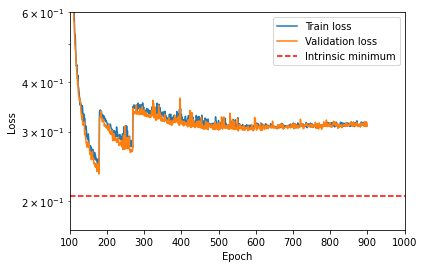

In [21]:
NDE_theta.plot_loss(0.206)
plt.yscale('log')

plt.xlim(100, 1000)
plt.ylim(0, 0.6)

In [65]:
samples = NDE_theta.sample(5000)
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
_samples = np.hstack([prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]),
                      _samples_unt[:, 3:-1], 
                      _samples_unt[:, -1:]])

0 5000
>40 0


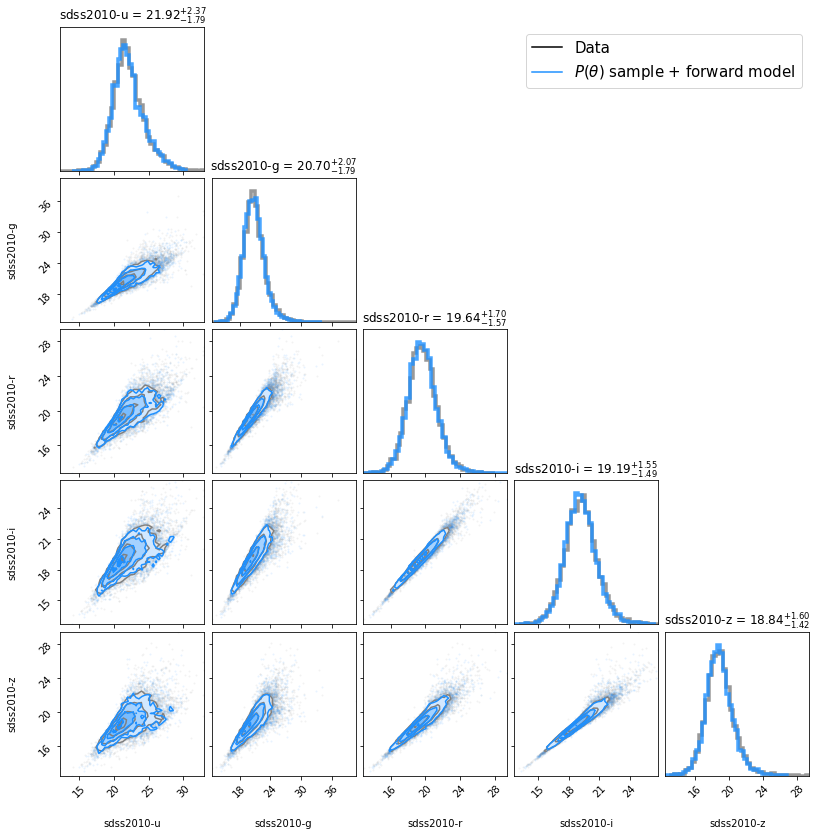

In [66]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = gama_filters

figure = corner.corner(X_vali,#.cpu().detach().numpy(), 
                       color='gray', labels=labels, bins=40,
                       smooth=0.2, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(
#     inverse_transform_nmf_params_given_z(samples, NDE_theta.NDE_prior, NDE_theta.cdf_z), 
    inverse_transform_nmf_params(samples, NDE_theta.NDE_prior),
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir, SNR=1,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=40,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.2, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [70]:
true_params_unt = np.load('./NDE/GAMA/NMF/mock_ZH_params.npy')
true_params_unt = true_params_unt[np.random.randint(0, len(true_params_unt), 5000)]
true_params = np.hstack([prior.FlatDirichletPrior(4).transform(true_params_unt[:, :3]),
                      true_params_unt[:, 3:-1], 
                      true_params_unt[:, -1:]])

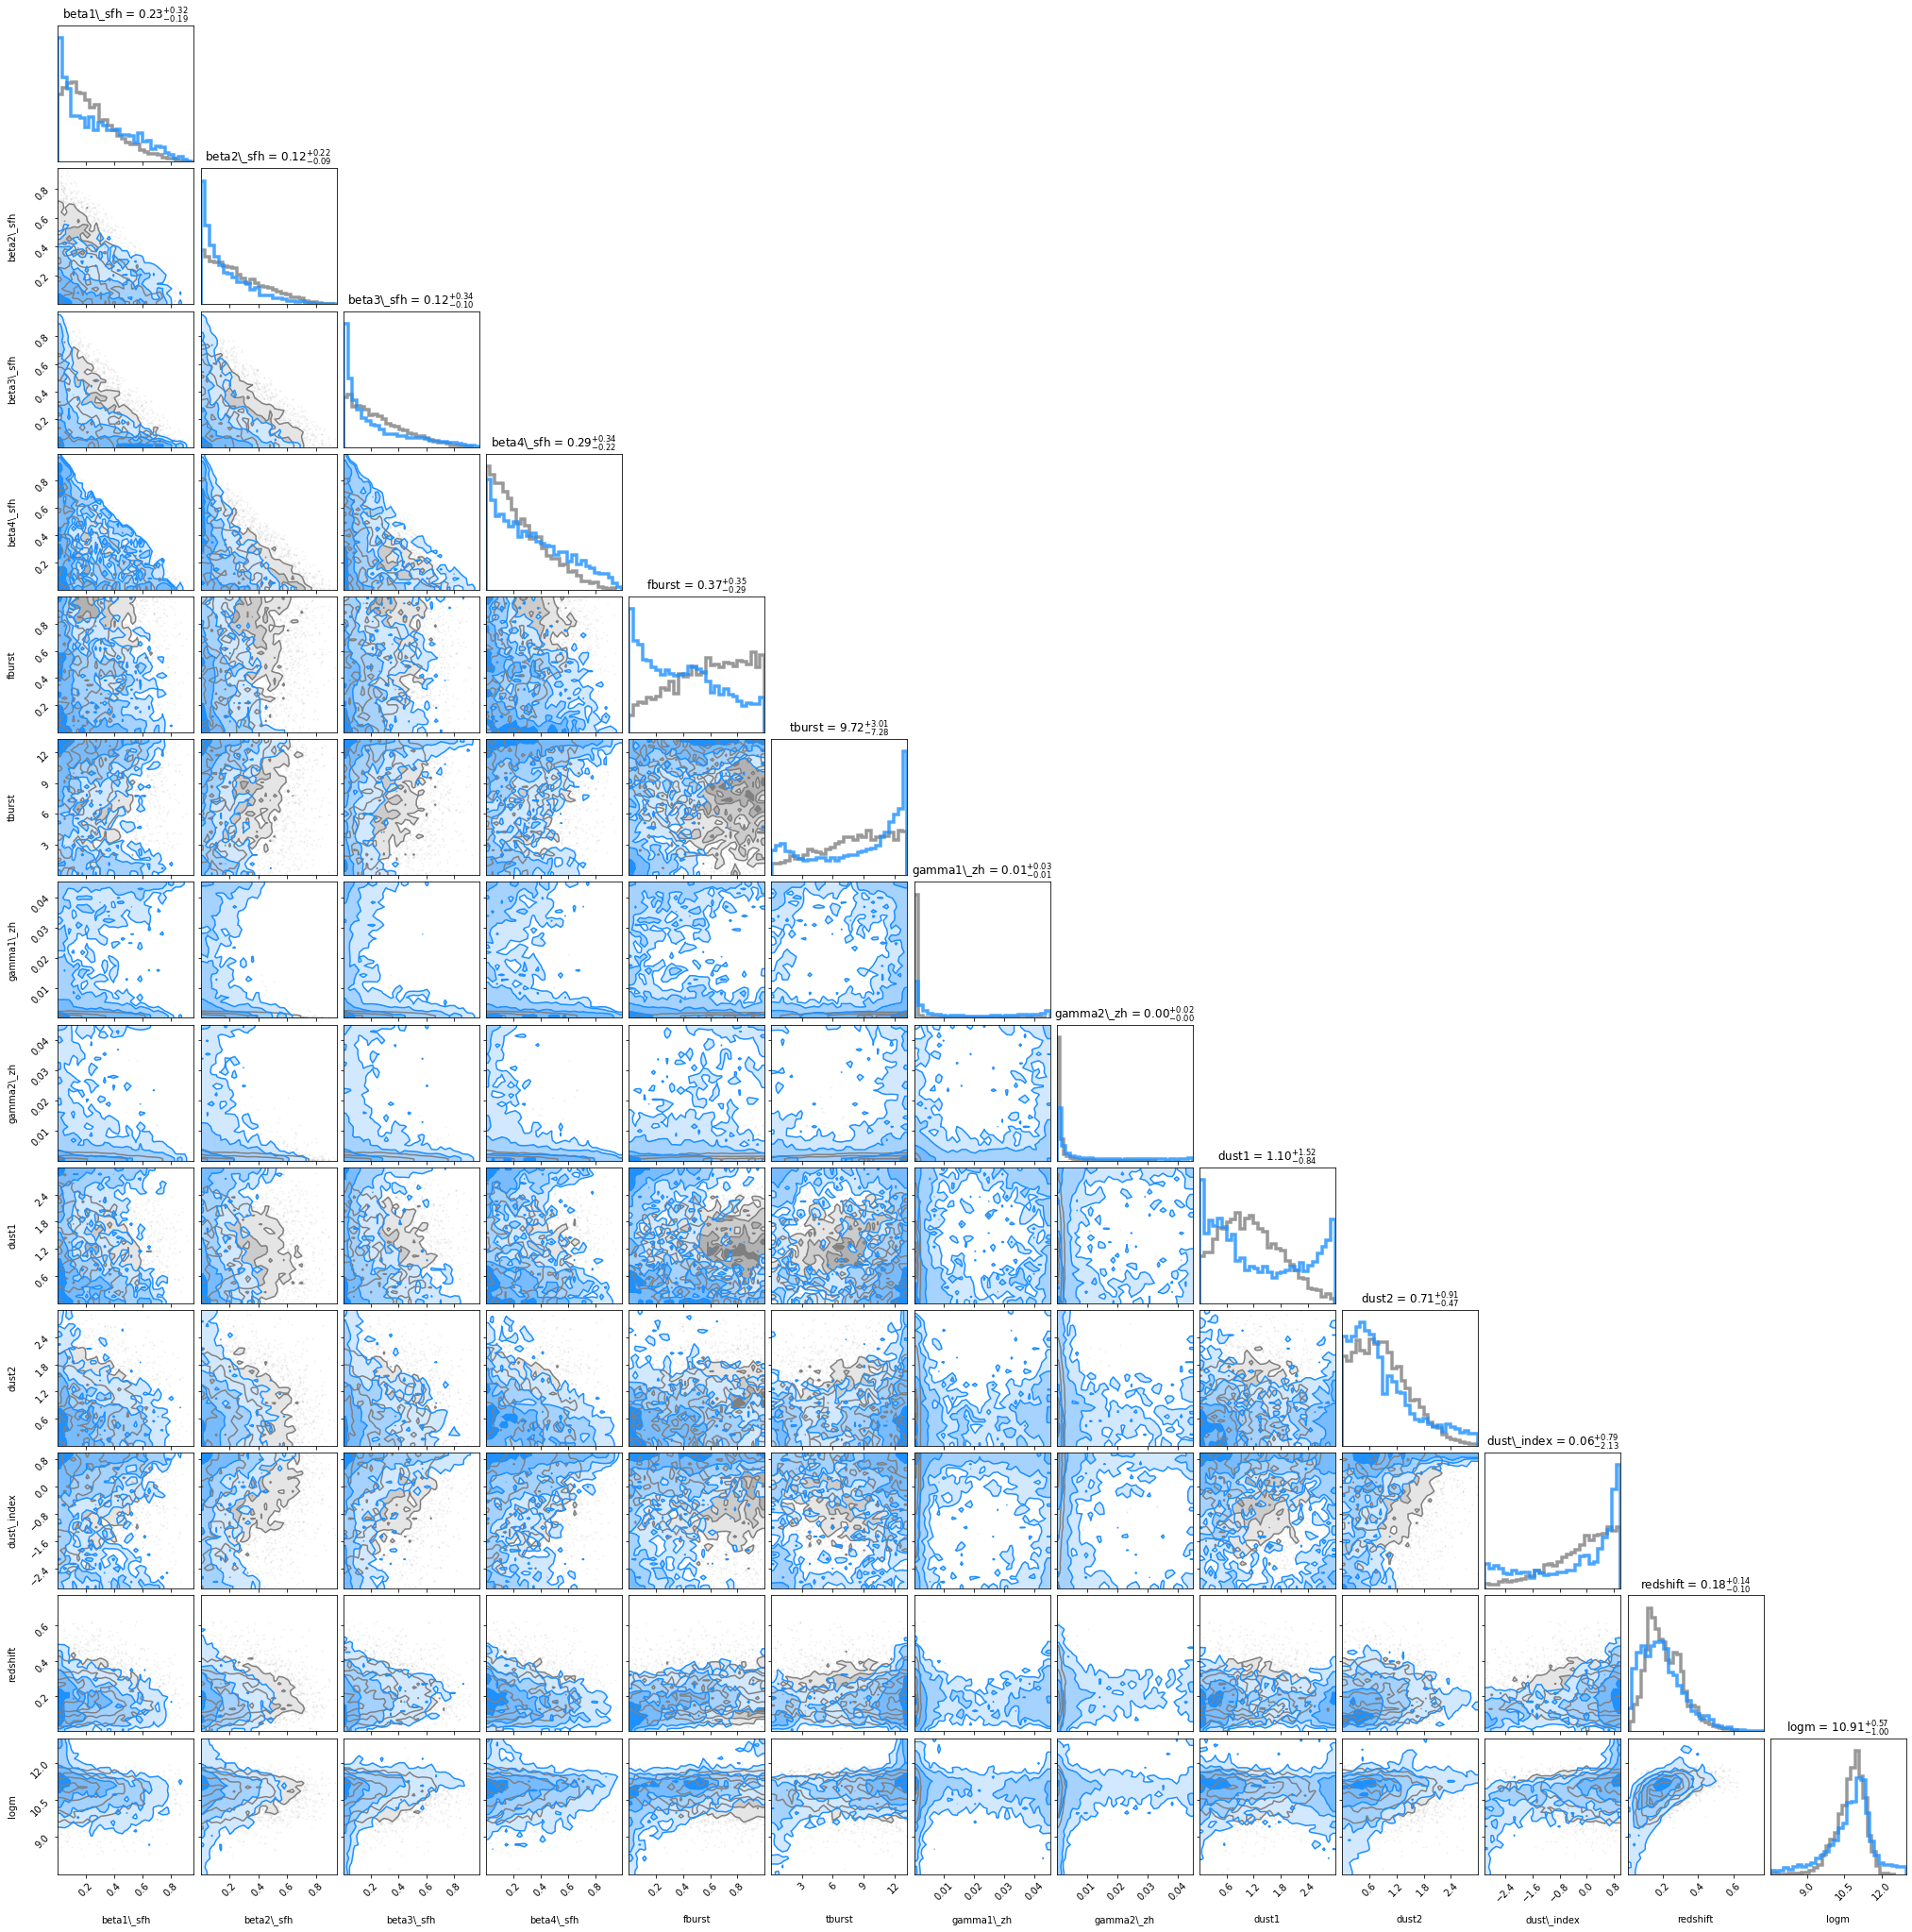

In [72]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

figure = corner.corner(true_params, 
                  labels=_labels, bins=30,
                  color='gray', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)


nf_plot = corner.corner(_samples, 
                        fig=figure,
                  labels=_labels, bins=30,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

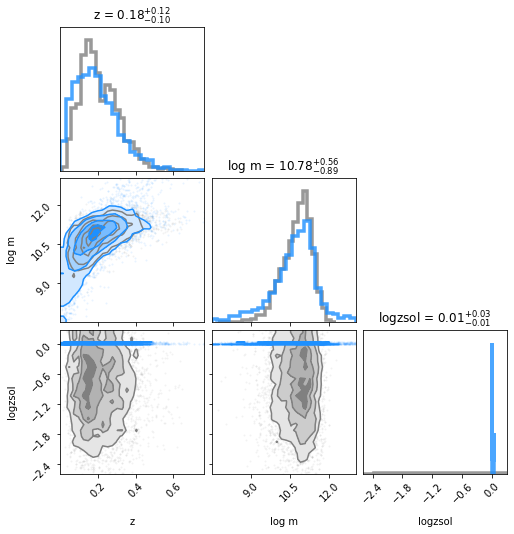

In [25]:
z_mass_met = np.hstack([true_params[:, -2:], true_params[:, 6:7]])
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
#                        range=[[0, 1], [8, 13], [-2, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples[:, -2:-1], _samples[:, -1:], _samples[:, 6:7]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [46]:
np.sort(true_params[:, -2])

array([0.00657144, 0.0066278 , 0.00664884, ..., 0.97983915, 0.98794556,
       0.9928388 ])

(array([193., 466., 620., 746., 738., 645., 528., 369., 229., 154., 125.,
         67.,  36.,  32.,  12.,  10.,   8.,   5.,   3.,   1.,   6.,   2.,
          0.,   1.,   4.]),
 array([0.00657144, 0.04602214, 0.08547283, 0.12492352, 0.16437422,
        0.20382491, 0.24327561, 0.2827263 , 0.322177  , 0.36162769,
        0.40107839, 0.44052908, 0.47997977, 0.51943047, 0.55888116,
        0.59833186, 0.63778255, 0.67723325, 0.71668394, 0.75613463,
        0.79558533, 0.83503602, 0.87448672, 0.91393741, 0.95338811,
        0.9928388 ]),
 <BarContainer object of 25 artists>)

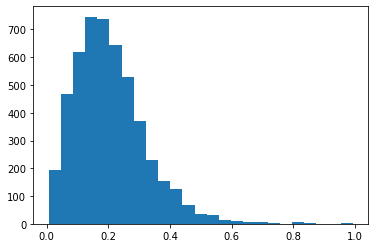

In [66]:
plt.hist(true_params[:, -2], bins=25)
# plt.xlim(0, 0.15)

In [64]:
from popsed.models import NMF_ZH
model = NMF_ZH(burst=True, peraa=True)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [63]:
params = np.hstack([_samples[:, -1:], _samples[:, :-1]])

In [69]:
sfr = np.zeros(len(params))
age = np.zeros(len(params))
zmw = np.zeros(len(params))

for i in range(len(params)):
    tt = params[i]
    sfr[i] = model.avgSFR(tt[:-1], zred=tt[-1], dt=1)
    age[i] = model.tage_MW(tt[:-1], zred=tt[-1])
    zmw[i] = model.Z_MW(tt[:-1], zred=tt[-1])

In [78]:
redshift = params[:, -1]
logmstar = params[:, 0]
logzsol = np.log10(zmw / 0.019)

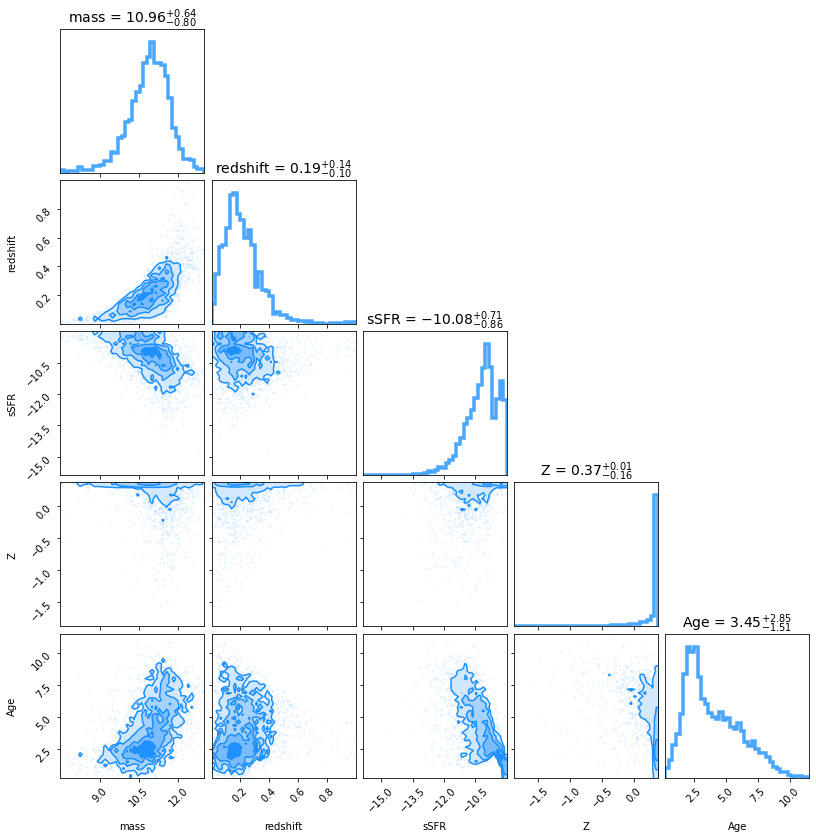

In [79]:
figure = corner.corner(np.vstack([logmstar, redshift, np.log10(sfr)-logmstar, logzsol, age]).T, 
                  labels=['mass','redshift', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = figure.get_axes()[2]
# ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

In [35]:
a, b = np.histogram(z_mass_truth[:, 0].ravel(), bins=35, range=(0, 0.5))
b[np.argmax(a)]

0.15714286

In [59]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()

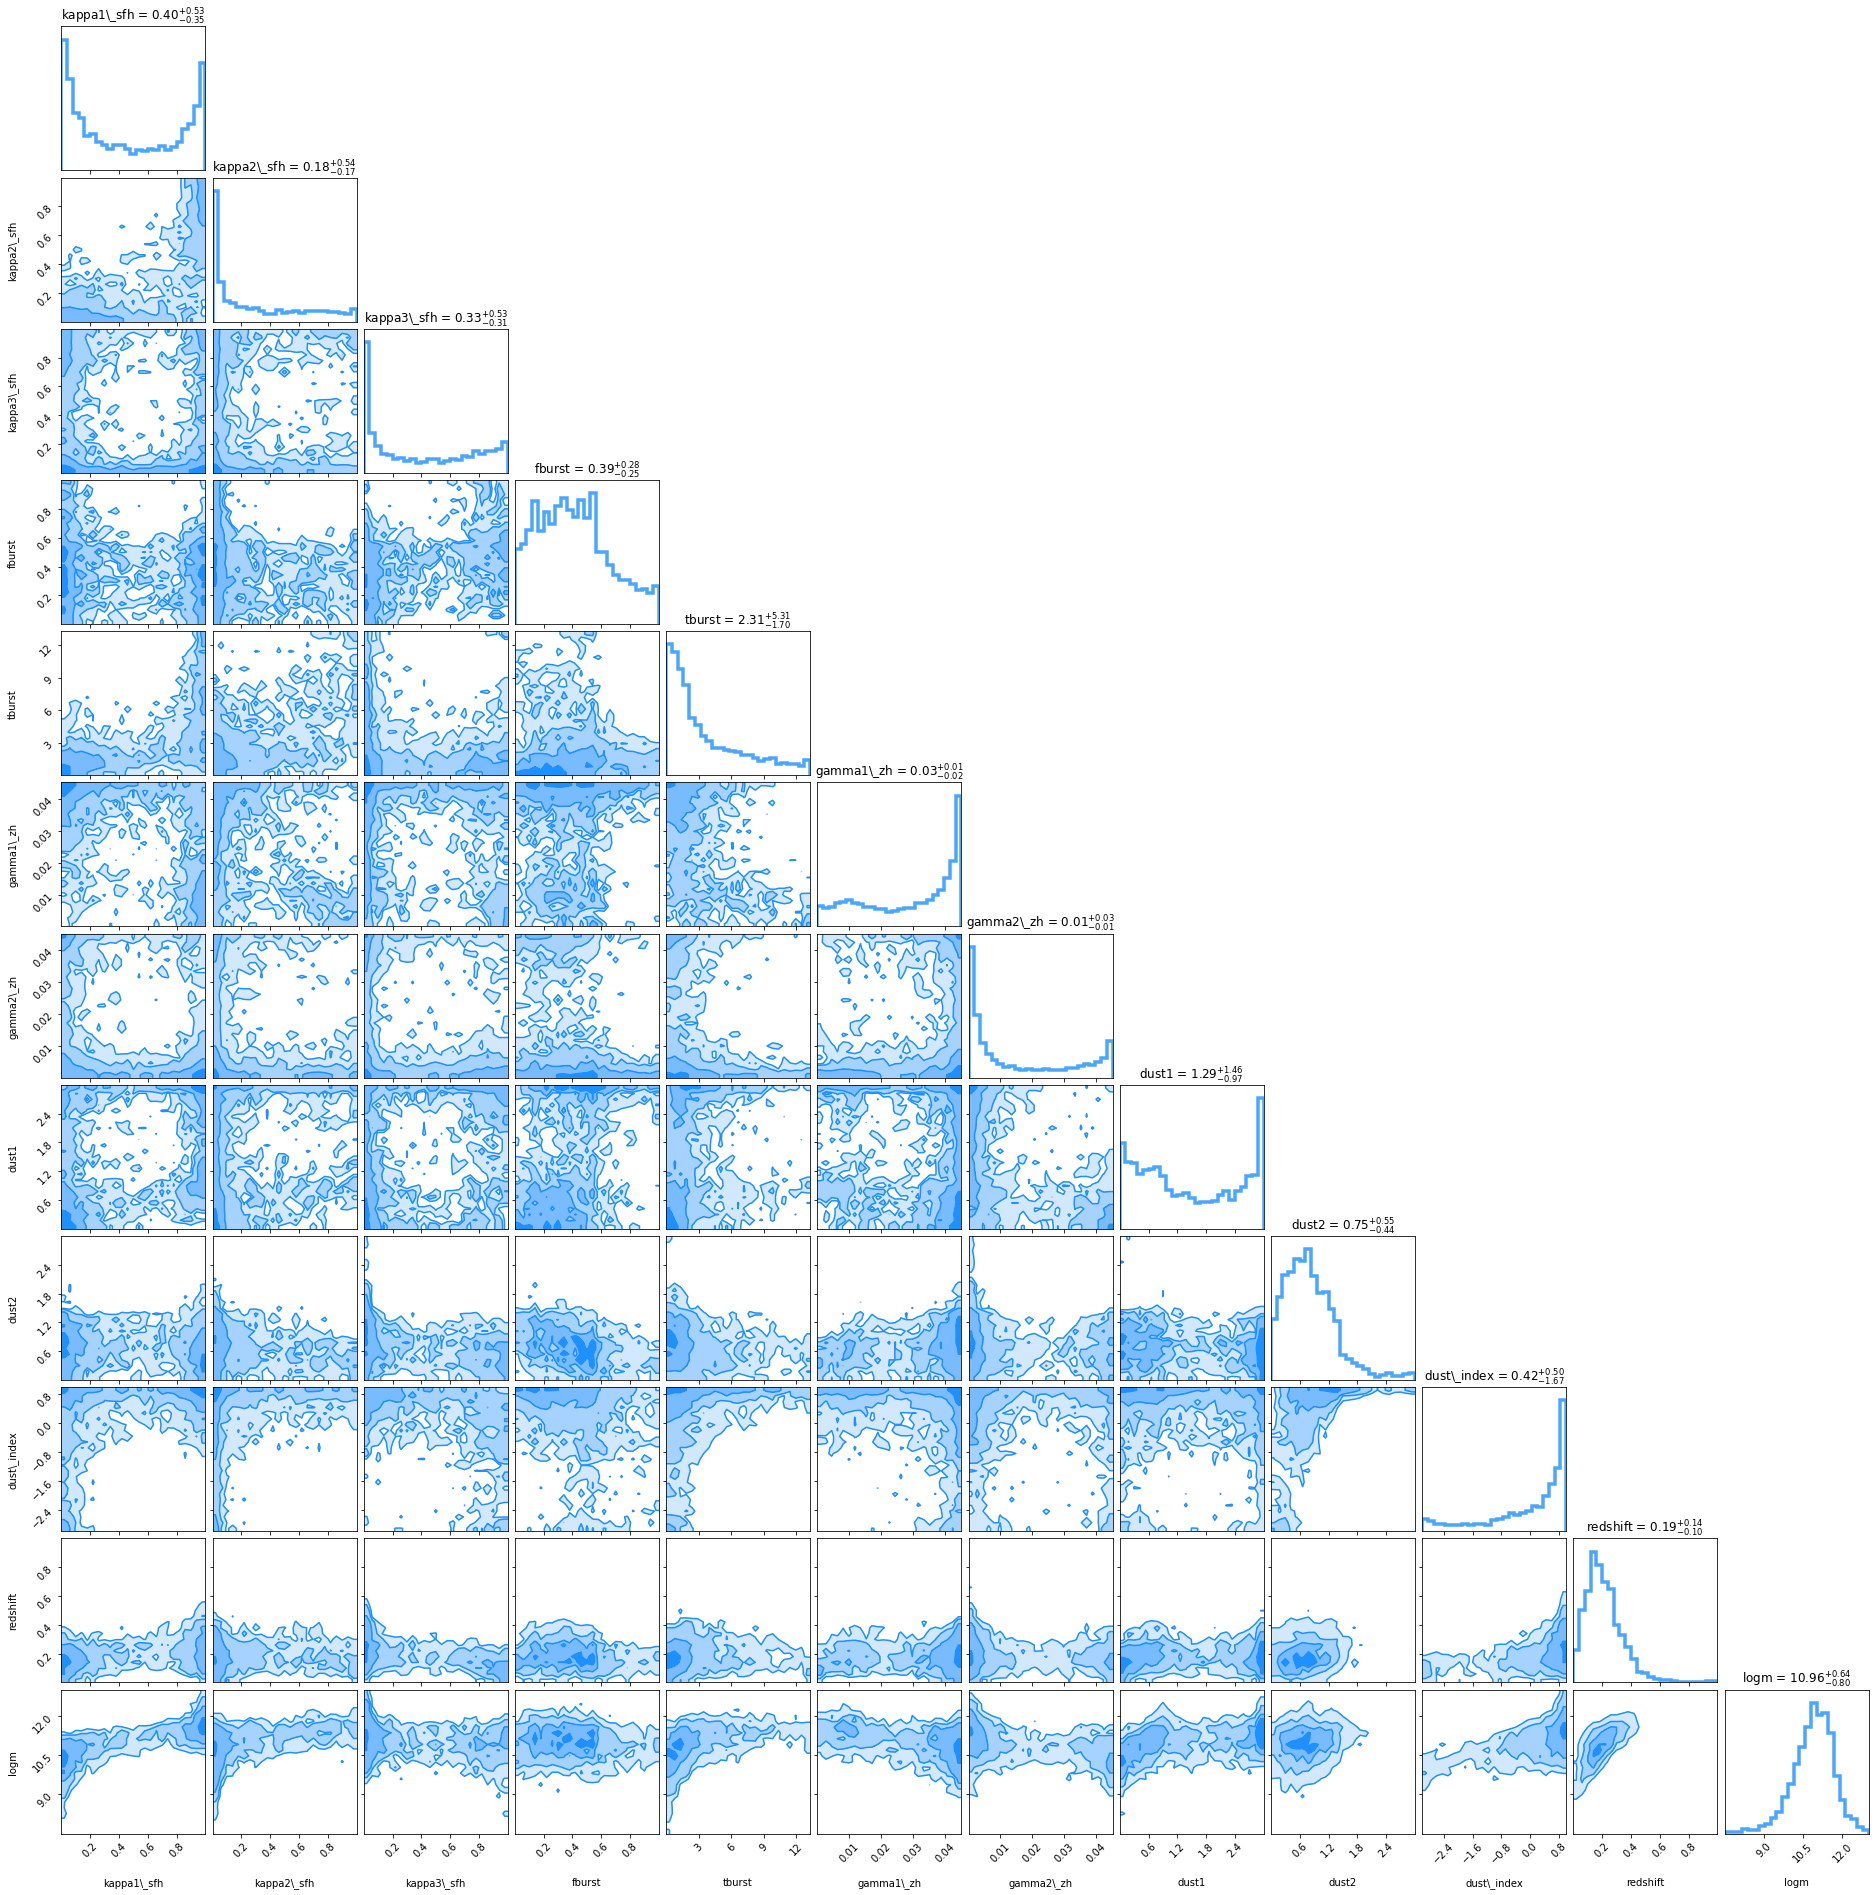

In [60]:
_labels = [f'kappa{i}_sfh' for i in range(1,4)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

nf_plot = corner.corner(_samples_unt, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))